In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from tensorflow.keras import layers, Model, losses, optimizers, mixed_precision
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

2025-05-25 04:02:30.903530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748145751.091958      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748145751.147089      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Globals

In [2]:
# Use mixed precision for faster training time
mixed_precision.set_global_policy("mixed_float16")

In [3]:
ROOT_DATASET = "/kaggle/input/11-785-fall-20-homework-2-part-2"
TRAIN_DS_PATH = os.path.join(ROOT_DATASET, "classification_data", "train_data")
TRAIN_DS_PATH_CLF = "/kaggle/working/train_data"
VAL_DS_PATH = os.path.join(ROOT_DATASET, "classification_data", "val_data")
VAL_DS_PATH_CLF = "/kaggle/working/val_data"
TEST_DS_PATH = os.path.join(ROOT_DATASET, "classification_data", "test_data")
TEST_DS_PATH_CLF = "/kaggle/working/test_data"
VERIFICATION_TXT = os.path.join(ROOT_DATASET, "verification_pairs_val.txt")
VERIFICATION_FOLDER = os.path.join(ROOT_DATASET, "verification_data")

IMG_SIZE = 224
CHANNELS = 3
CLASSES = len(os.listdir(TRAIN_DS_PATH))
CLASSES_REDUCED = 100
BATCH_SIZE = 64
GLOBAL_BATCH_SIZE = 128
# GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
EMBED_DIMS = 1024

# Prune training dataset

Reduce training set to 100 classes. Only 100 faces per person will be kept. Skip that person if they don't have enough images

In [4]:
count = 0

for faces_dir in os.listdir(TRAIN_DS_PATH):
    orig_dir = os.path.join(TRAIN_DS_PATH, faces_dir)
    dest_dir = os.path.join(TRAIN_DS_PATH_CLF, faces_dir)
    images = os.listdir(orig_dir)
    images_count = len(images)
    if images_count <= 100:
        continue
    if count >= CLASSES_REDUCED:
        break

    shutil.copytree(orig_dir, dest_dir)
    shutil.copytree(os.path.join(VAL_DS_PATH, faces_dir), os.path.join(VAL_DS_PATH_CLF, faces_dir))
    shutil.copytree(os.path.join(TEST_DS_PATH, faces_dir), os.path.join(TEST_DS_PATH_CLF, faces_dir))
    images = os.listdir(dest_dir)
    for image in images[100:]:
        os.remove(os.path.join(dest_dir, image))
    count += 1
assert count == CLASSES_REDUCED

# Create lookup table for labels

In [4]:
# List all folder labels
label_names = [d for d in os.listdir(TRAIN_DS_PATH)]

# Keys from labels
keys = tf.constant(label_names)
# Values from a range of [0,n-1] with n being classes length
values = tf.constant(range(len(label_names)), dtype=tf.int64)

# Create lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys, values),
    default_value=-1
)


# Repeat the same but for 100 class dataset
label_names_clf = [d for d in os.listdir(TRAIN_DS_PATH_CLF)]

keys_clf = tf.constant(label_names_clf)
values_clf = tf.constant(range(len(label_names_clf)), dtype=tf.int64)

table_clf = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys_clf, values_clf),
    default_value=-1    
)

I0000 00:00:1748145764.400731      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748145764.401430      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data Preparation

## Preprocessing Functions

In [5]:
def process_path(path):
    # Get label
    splitted = tf.strings.split(path, os.path.sep)
    label = splitted[-2]
    label = table.lookup(label)
    # Get processed image
    img = get_img(path)
    return img, label

def get_img(path):
    img = tf.io.read_file(path)
    # Get image as tensor data
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize image. Currently will be resized to (224, 224)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS]) 
    return img

def process_path_clf(path):
    # Get label
    splitted = tf.strings.split(path, os.path.sep)
    label = splitted[-2]
    label = table_clf.lookup(label)
    # Get processed image
    img = get_img(path)
    return img, label

def process_verification(line):
    # Preprocess the file line
    line = tf.strings.strip(line)
    splitted = tf.strings.split(line, " ")
    # Get first image path
    img_path1 = splitted[0]
    # Get second image path
    img_path2 = splitted[1]
    # Get label
    label = splitted[2]

    # Get both images
    img1 = get_img(tf.strings.join([ROOT_DATASET, img_path1], separator=os.path.sep))
    img2 = get_img(tf.strings.join([ROOT_DATASET, img_path2], separator=os.path.sep))

    return img1, img2, label

## Loading Dataset

In this notebook, I will load the data with tf.data.Dataset for more granular control 

In [6]:
# Get verification_pairs_val.txt contents
verification_lists = []
with open(VERIFICATION_TXT, "r") as f:
    verification_lists = f.readlines()

# Turn dataset into tf.data.Dataset
train_ds =  tf.data.Dataset.list_files(f"{TRAIN_DS_PATH}/*/*")
train_ds_clf = tf.data.Dataset.list_files(f"{TRAIN_DS_PATH_CLF}/*/*")
val_ds_clf =  tf.data.Dataset.list_files(f"{VAL_DS_PATH_CLF}/*/*")
test_ds_clf =  tf.data.Dataset.list_files(f"{TEST_DS_PATH_CLF}/*/*")
verification_ds = tf.data.Dataset.from_tensor_slices(verification_lists)

The dataset will be processed from containing paths, into containing images along with labels

There are several techniques that have been used here for optimizing the training speed, those are:
- num_parallel_calls: This argument ensures that the mapping was done in a parallel way
- batch: The higher the batch, the more GPU resource will be used to offload CPU resource. As in the training environment the GPU has 16GB VRAM, a higher number of 128 batches will be used
- prefetch: Using prefetch will ensure that while the model is training, the next batch of data will be processed at the same time. Essentially a parallel computing technique

Caching is not used here as the dataset is large (~320k images) and will cause OOM error

In [7]:
# TODO: Divide process_path to memory and time consuming
# TODO: Batch then map

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).batch(GLOBAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds_clf = train_ds_clf.map(process_path_clf, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).batch(GLOBAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_clf = val_ds_clf.map(process_path_clf, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).batch(GLOBAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_clf = test_ds_clf.map(process_path_clf, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).batch(GLOBAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
verification_ds = verification_ds.map(process_verification, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).batch(1).prefetch(tf.data.AUTOTUNE)

In [9]:
# There are around 380672 (give or take 64 images) in the dataset
print(f"Length of original dataset: {len(train_ds) * GLOBAL_BATCH_SIZE}")
print(f"Length of pruned dataset: {len(train_ds_clf) * GLOBAL_BATCH_SIZE}")

Length of original dataset: 380672
Length of pruned dataset: 10112


# Evaluation Function

## Similarity Metric

In [10]:
def compute_similarity(emb1, emb2, metric):
    if metric == "euclidean":
        return tf.norm(emb1-emb2, ord="euclidean").numpy()
    elif metric == "cosine":
        distance = tf.keras.losses.cosine_similarity(emb1, emb2)
        return -distance.numpy()[0]
    else:
        raise Exception("Metric unrecognized")

## AUC and ROC Curve With Best Threshold

In [28]:
def show_roc_auc(model, metric="euclidean"):
    distances = []
    true_labels = []

    # Calculate distances for each verification entry in .txt file
    for batch in tqdm(verification_ds, desc=f"Processing validation"):
        img1, img2, true_label = batch
        # Get embeddings of both images
        emb1, emb2 = model(tf.concat([img1, img2], axis=0))
        # Compute similarity
        distance = compute_similarity(emb1, emb2, metric)
        # Append distances and labels to full list
        distances.append(distance)
        true_labels.append(true_label.numpy())

    # Format distances and true_labels as numpy
    distances = np.array(distances)
    true_labels = np.array([int(label[0].decode()) for label in true_labels])

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, -distances) 
    # Get index of best threshold
    best_threshold_idx = np.argmax(tpr - fpr)
    # Get best threshold
    best_threshold = -thresholds[best_threshold_idx]
    # Get AUC score
    roc_auc = roc_auc_score(true_labels, -distances)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.annotate(
        f"Best threshold at {best_threshold}",
        (fpr[best_threshold_idx], tpr[best_threshold_idx]),
        xytext=(-100, 10),
        textcoords="offset points",
        arrowprops=dict(
            arrowstyle='->'
        )
    )
    plt.plot([0, 1], [0, 1], linestyle="--", label="Baseline (AUC = 0.5)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.show()
    return best_threshold

# Distributed Training Setup

In [13]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

# Supervised Learning

## Building Model

In [12]:
## USING TRANSFER LEARNING RESNET50
def classification_cnn_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
        include_top=False,
    )
    base_model.trainable = False
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(EMBED_DIMS, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(CLASSES_REDUCED)(x)
    model = Model(inputs, out)
    return model
classification_cnn_model().summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │        525,312 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 100)            │        102,500 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,264,612 (96.38 MB)

 Trainable params: 1,676,900 (6.40 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Model Training

Epoch 1/10


I0000 00:00:1748106350.616931     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748106350.616944     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


79/79 ━━━━━━━━━━━━━━━━━━━━ 51s 387ms/step - accuracy: 0.0057 - loss: 5.2654 - val_accuracy: 0.1890 - val_loss: 3.5201 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - accuracy: 0.1236 - loss: 3.7960 - val_accuracy: 0.2652 - val_loss: 3.0074 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - accuracy: 0.2105 - loss: 3.1745 - val_accuracy: 0.3354 - val_loss: 2.6907 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 292ms/step - accuracy: 0.2544 - loss: 3.0660 - val_accuracy: 0.3994 - val_loss: 2.5112 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.3169 - loss: 2.6615 - val_accuracy: 0.4146 - val_loss: 2.3540 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.3437 - loss: 2.5332 - val_accuracy: 0.4421 - val_loss: 2.2366 - learning_rate: 0.0010
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - accuracy: 0.3435 - loss: 2.4694 - val_

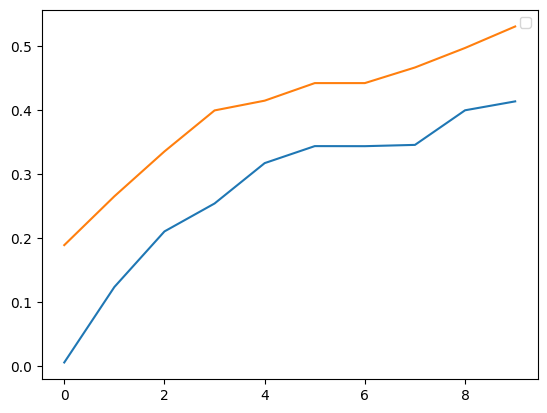

In [13]:
with strategy.scope():
    clf_model = classification_cnn_model()
    clf_model.compile(
        tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

history = clf_model.fit(train_ds_clf, validation_data=val_ds_clf, epochs=10, callbacks=[early_stopping, reduce_lr])

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend()
plt.show()

# Finetuning Model

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 64s 476ms/step - accuracy: 0.2342 - loss: 3.3268 - val_accuracy: 0.5183 - val_loss: 1.9553 - learning_rate: 1.0000e-05
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 370ms/step - accuracy: 0.4101 - loss: 2.3739 - val_accuracy: 0.5122 - val_loss: 1.8693 - learning_rate: 1.0000e-05
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 388ms/step - accuracy: 0.4863 - loss: 1.9405 - val_accuracy: 0.5488 - val_loss: 1.7866 - learning_rate: 1.0000e-05
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 383ms/step - accuracy: 0.4551 - loss: 1.9591 - val_accuracy: 0.5640 - val_loss: 1.6828 - learning_rate: 1.0000e-05
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 369ms/step - accuracy: 0.5274 - loss: 1.7243 - val_accuracy: 0.5518 - val_loss: 1.7137 - learning_rate: 1.0000e-05
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 374ms/step - accuracy: 0.5220 - loss: 1.7274 - val_accuracy: 0.5915 - val_loss: 1.5850 - learning_rate: 1.0000e-05
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 384ms/step - acc

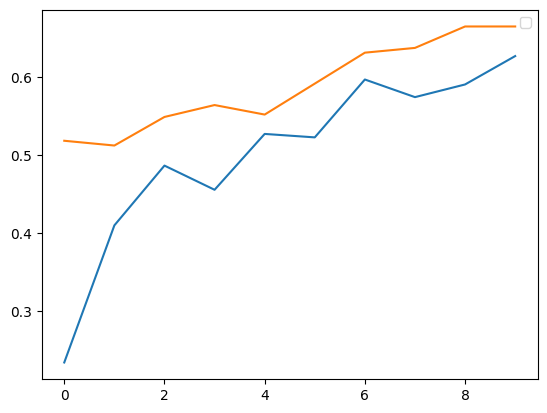

In [15]:
with strategy.scope():
    base_model = clf_model.layers[1]
    resnet_layer_count = base_model.layers
    freeze_layers = int(len(resnet_layer_count) * 0.75)
    
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    clf_model.compile(
        tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

history = clf_model.fit(train_ds_clf, validation_data=val_ds_clf, epochs=10, callbacks=[early_stopping, reduce_lr])

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend()
plt.show()

## Classification Model Evaluation

In [19]:
tf.keras.backend.clear_session()
clf_eval_model = Model(inputs=clf_model.input, outputs=clf_model.layers[-2].output)
del clf_model

Processing validation: 100%|██████████| 8805/8805 [35:07<00:00,  4.18it/s]


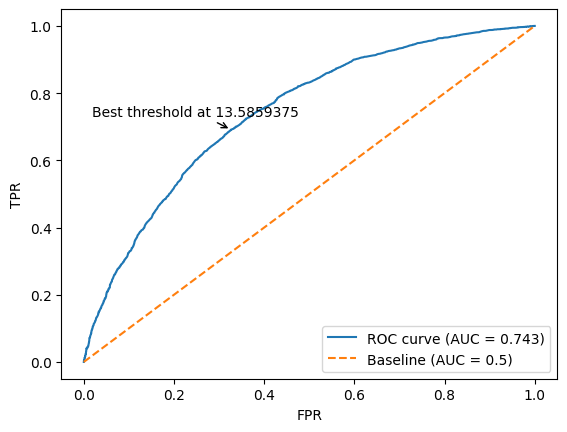

In [20]:
clf_threshold = show_roc_auc(clf_eval_model)

# Metric Learning (Triplet Loss)

## Building Metric Learning Model

In [31]:
def l2_norm(x):
    return tf.math.l2_normalize(x, axis=-1)

def metric_learning_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
        include_top=False,
    )
    base_model.trainable = False
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(EMBED_DIMS, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    out = tf.keras.layers.Lambda(l2_norm, input_shape=(EMBED_DIMS,), output_shape=(EMBED_DIMS,))(x)
    model = Model(inputs, out)
    return model

metric_learning_model().summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1024)           │              0 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,685,888 (97.98 MB)

 Trainable params: 2,098,176 (8.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Triplet Mask For Validating Triplets

To get the positive mask, we want to build a 2D tensor with shape of (BATCH_SIZE, BATCH_SIZE)

The row and column is comprised of the "labels" vector. 

Given $i$ (row) and $j$ (column), mask$_{ij}$ is $true$ if label$_i$ == label$_j$

In addition to the above condition, it should also only be $true$ if $i$ and $i$ is NOT the same (Can't have the same image as both anchor and positive)

<br>
To get the negative mask,  mask$_{ij}$ is $true$ if label$_i$ != label$_j$ (Condition flipped from the positive mask)

The same condition of $i$ and $j$ not being the same is still valid

In [13]:
def get_triplet_mask(labels):
    '''
        Args:
            labels: Tensor of labels. Shape of (N,)
        Return:
            (positive_mask, negative_mask): A tuple of positive mask (N, N) and negative mask (N, N)
    '''
    # Reshape labels to (N, 1)
    labels = tf.reshape(labels, (-1 , 1))
    labels_are_the_same = tf.equal(labels, tf.transpose(labels))
    labels_are_not_the_same = ~labels_are_the_same
    # Get identity matrix of N range. Flip the identity matrix boolean so that if i == j = false
    indices_are_not_the_same = tf.logical_not(tf.eye(tf.shape(labels)[0], dtype=tf.bool))

    # Get labels that has same labels (same person) as positive mask
    positive_mask = tf.logical_and(indices_are_not_the_same, labels_are_the_same)
    positive_mask = tf.cast(positive_mask, dtype=tf.float16)

    # Get labels that has different labels (different person) as negative mask
    negative_mask = tf.logical_and(indices_are_not_the_same, labels_are_not_the_same)
    negative_mask = tf.cast(negative_mask, dtype=tf.float16)
    
    return (positive_mask, negative_mask)

## Euclidian Distance Matrix Function

Uses the euclidian distance matrix trick (https://samuelalbanie.com/files/Euclidean_distance_trick.pdf)

Computes the euclidian distance
    $$(X_i - X_j) . (X_i - X_j)^T$$
As the following equation
    $$||X_i||_2^2 - 2Xi^TX_j + ||X_j||_2^2$$ 

To do the computation, we need to get the value of:

$||X_i||_2^2$ : Squared L2 norm of X_i

$X_i^TX_j$ : Dot product of X_i and X_j

$||X_i||_2^2$ : Squared L2 norm of X_j

All of the variables above can be taken from the dot product of $<X_i,X_j>$

In [14]:
def compute_pairwise_euclidian_distance(embeddings):
    '''
        Args:
            embeddings: Tensors. A batch of embeddings. (BATCH_SIZE, EMBED_DIMS)
        Return:
            euclidian_distances: Tensors. Euclidian distance of each embeddings to each of the other embeddings. (BATCH_SIZE, BATCH_SIZE)
    '''

    # Dot product of <xi, xj>. Outputs shape of (BATCH_SIZE, BATCH_SIZE)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
        
    
    # Squared L2 norm of the dot product. Outputs shape of (BATCH_SIZE,)
    squared_l2_norm = tf.linalg.diag_part(dot_product)
    # Squared L2 norm of xi. Outputs shape of (1, BATCH_SIZE)
    squared_l2_xi = tf.expand_dims(squared_l2_norm, 0)
    # Squared L2 norm of xj. Outputs shape of (BATCH_SIZE, 1)
    squared_l2_xj = tf.expand_dims(squared_l2_norm, 1)

    # Computing euclidian distance matrix. Formula used is 
    distance = squared_l2_xi - (2*dot_product) + squared_l2_xj
    # For computing errors
    distance = tf.maximum(distance, 0)
    
    return distance

## Triplet Loss Function

This function uses only the hardest triplet for each anchor in the batch. The formula used for the triplet loss is 
$$L = max((f(x_a) - f(x_p)) - (f(x_a) - f(x_n)) + \alpha, 0)$$

In [15]:
# with strategy.scope():
def triplet_loss(embeddings, labels, margin):
    '''
        Args:
            embeddings: Tensors of embeddings output from the model. Shape of (BATCH_SIZE, EMBED_DIM)
            labels: Tensors of labels for each embeddings. Shape of (BATCH_SIZE,)
            margin: Margin for the triplet loss formula. The bigger the margin, the farther apart different faces are from each other
        Return:
            triplet_loss: Loss computed
    '''
    # Get pairwise Euclidean distance
    pairwise_distance = compute_pairwise_euclidian_distance(embeddings)

    # Get masks to filter out invalid pairs
    masks = get_triplet_mask(labels)
    positive_mask = masks[0]
    negative_mask = masks[1]

    # Get valid anchors positive pairs
    valid_anchor_positive_pairs = tf.multiply(pairwise_distance, positive_mask)
    # Get only hardest positive pairs by getting the longest distance pairs
    # Since we want the positive pairs to have a close distance to the anchor, the hardest pair will be the one that's really far
    hardest_anchor_positive_pairs = tf.reduce_max(valid_anchor_positive_pairs, axis=1, keepdims=True)

    # Get valid anchor negative pairs
    # Can't just do reduce_min since if we filter out invalid values by the mask (that is, zeroing them out), then reduce_min is going to pickup those 0 values
    max_anchor_negative_pairs = tf.reduce_max(pairwise_distance, axis=1, keepdims=True)
    # To avoid the above issue, a really large value (in this case the maximum value on each anchor pairs) is added to each invalid pairs
    # Essentially removing invalid values by giving them a really large value
    valid_anchor_negative_pairs = pairwise_distance + max_anchor_negative_pairs * (1.0 - negative_mask)
    # Then get the hardest negative pairs by getting the closest distance pairs
    # Since we want the negative pairs to be far away from the anchor, the hardest pair will be the one that's really close to the anchor
    hardest_anchor_negative_pairs = tf.reduce_min(valid_anchor_negative_pairs, axis=1, keepdims=True)

    # Calculate triplet loss
    triplet_loss = tf.maximum(hardest_anchor_positive_pairs - hardest_anchor_negative_pairs + margin, 0.0)
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

## Model Training

### Train Step Function

In [16]:
@tf.function
def train_step(batch):
    # Get images and labels
    images = batch[0]
    labels = batch[1]

    with tf.GradientTape() as tape:
        # Produce embeddings
        embeddings = metric_model(images)
        # Get loss
        loss = triplet_loss(embeddings, labels, 0.2)
        # Get gradients
        grads = tape.gradient(loss, metric_model.trainable_variables)
    # Apply gradients
    optimizer.apply_gradients(zip(grads, metric_model.trainable_variables))
    return loss

### Training Loop

In [32]:
loss_history = []

initial_lr = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=3000,
    decay_rate=0.95,
    staircase=True
)

metric_model = metric_learning_model()
optimizer = tf.keras.optimizers.Adam(lr_schedule)

for epoch in range(2):
    tmp_loss = []
    for batch in tqdm(train_ds, desc=f"Epoch: {epoch}"):
        loss = train_step(batch)
        tmp_loss.append(loss)
    current_loss = sum(tmp_loss) / len(tmp_loss)
    print(f"Epoch {epoch} loss: {current_loss}")
    loss_history.append(current_loss)

Epoch: 0: 100%|██████████| 2974/2974 [16:17<00:00,  3.04it/s]


Epoch 0 loss: 0.04925537109375


Epoch: 1: 100%|██████████| 2974/2974 [16:06<00:00,  3.08it/s]

Epoch 1 loss: 0.04742431640625


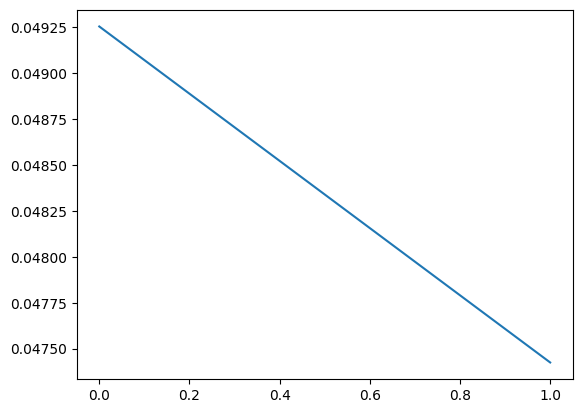

In [35]:
plt.plot(loss_history)
plt.show()

## Metric Learning Model Evaluation

Processing validation: 100%|██████████| 8805/8805 [29:45<00:00,  4.93it/s]


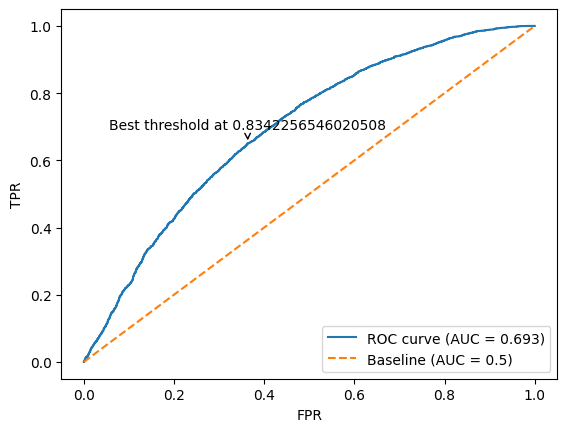

In [34]:
tf.keras.backend.clear_session()
metric_threshold = show_roc_auc(metric_model)

## Saving Metric Learning Model and Threshold

In [33]:
metric_model.save("metric_learning_model.keras")

with open("threshold.txt", "w") as f:
    # f.write("clf_threshold,metric_threshold\n")
    f.write(str(clf_threshold) + "," + str(metric_threshold))